In [1]:
# all the packages you need
from __future__ import division
import sys
import numpy as np
import time
import scipy.io as io
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# synthetic data generator
# n is number of samples, d is number of dimensions, k is number of nonzeros in w, sigma is std of noise, 
# X is a n x d data matrix, y=Xw+w_0+noise is a n-dimensional vector, w is the true weight vector, w0 is true intercept
def DataGenerator(n = 50, d = 75, k = 5, sigma = 10.0, w0 = 0.0, seed = 256):
    
    np.random.seed(seed)
    X = np.random.normal(0,1,(n,d))
    w = np.random.binomial(1,0.5,k)
    noise = np.random.normal(0,sigma,n)
    w[w == 1] = 10.0
    w[w == 0] = -10.0
    w = np.append(w, np.zeros(d - k))
    y = X.dot(w) + w0 + noise
    return (X, y, w, w0)

In [3]:
# initialization of W for lasso by least square regression or ridge regression
def Initialw(X, y):

    n, d = X.shape
    # increment X
    if sparse.issparse(X):
        XI = sparse.hstack((X, np.ones(n).reshape(n,1)))
    else:
        XI = np.hstack((X, np.ones(n).reshape(n,1)))

    if sparse.issparse(X):
        if n >= d:
            w = sparse.linalg.lsqr(XI, y)[0]
        else:
            w = sparse.linalg.inv(XI.T.dot(XI) + 1e-3 * sparse.eye(d+1)).dot(XI.T.dot(y))
            w = w.T
    else:
        if n >= d:
            w = np.linalg.lstsq(XI, y)[0]
        else:
            w = np.linalg.inv(XI.T.dot(XI) + 1e-3 * np.eye(d+1)).dot(XI.T.dot(y))
 
    return (w[:d], w[d])

In [4]:
# Helper and example function of sparse matrix operation for Problem 2.5
# W: a scipy.sparse.csc_matrix
# x: a vector with length equal to the number of columns of W
# In place change the data stored in W,
# so that every row of W gets element-wise multiplied by x
def cscMatInplaceEleMultEveryRow(W, x):
    indptr = W.indptr
    last_idx = indptr[0]
    for col_id, idx in enumerate(indptr[1:]):
        if idx == last_idx:
            continue
        else:
            W.data[last_idx:idx] *= x[col_id]
            last_idx = idx

Indices of non-zero weight entries: [ 0  1  2  3  4 11 12 25 34 36 52 63 71]


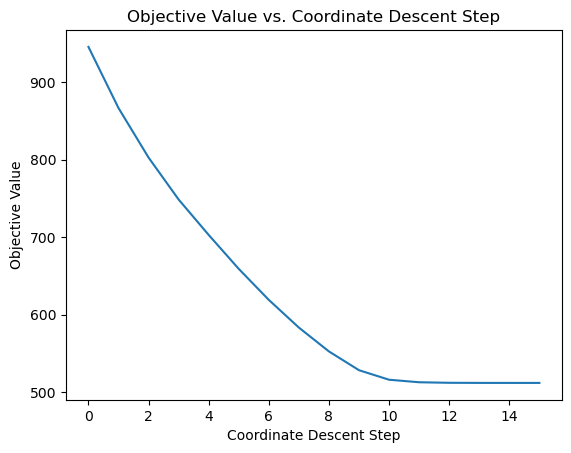

In [5]:
# Sub-Problem 1
# TODO: coordinate descent of lasso, note lmda stands for lambda
def lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
    #########TODO##########
    n, d = X.shape
    w, w0 = Initialw(X, y)  # Initialize weights and intercept using least squares regression or ridge regression
    
    objective_values = []  #plotting
    
    for step in range(max_iter):
        w_prev = np.copy(w)
        for j in range(d):
            r = y - X.dot(w) - w0 + X[:, j] * w[j]
            z = X[:, j].dot(r)
            if z < -lmda:
                w[j] = (z + lmda) / np.dot(X[:, j], X[:, j])
            elif z > lmda:
                w[j] = (z - lmda) / np.dot(X[:, j], X[:, j])
            else:
                w[j] = 0.0
        
        # Update intercept
        w0 = np.mean(y - X.dot(w))
        
        # Compute objective value
        objective = 0.5 * np.linalg.norm(y - X.dot(w) - w0) ** 2 + lmda * np.linalg.norm(w, ord=1)
        objective_values.append(objective)
        
        # Check convergence
        if np.max(np.abs(w - w_prev)) <= epsilon:
            break
            
        if step == max_iter - 1:
            print("Maximum number of iterations reached.")
            break
    
    
    return w, w0, objective_values

n = 50
m = 75
num_nonzero = 5
sigma = 1.0
theta0 = 0.0
lmda = 10.0  # lambda value for Lasso regularization
epsilon = 0.01  # convergence threshold
max_iter = 100  # maximum number of iterations

#synthetic data
X, y, _, _ = DataGenerator(n, m, num_nonzero, sigma, theta0)

# Solve Lasso
lasso_weights, lasso_intercept, objective_values = lasso(X, y, lmda=lmda, epsilon=epsilon, max_iter=max_iter)

# Report indices of non-zero weight entries
non_zero_indices = np.where(lasso_weights != 0)[0]
print("Indices of non-zero weight entries:", non_zero_indices)

# Plot objective value vs. coordinate descent step
plt.plot(objective_values)
plt.xlabel('Coordinate Descent Step')
plt.ylabel('Objective Value')
plt.title('Objective Value vs. Coordinate Descent Step')
plt.show()


In [17]:
#using different lambdas:
n = 50
m = 75
sigma = 1.0
theta0 = 0.0
np.random.seed(256)
X, y, _, _= DataGenerator(n, m, 5, sigma, theta0)


lambda_values = [0.01, 0.1, 1.0, 10.0]

for lmda in lambda_values:
    print(f"Lambda: {lmda}")
    lasso_weights, lasso_intercept, _ = lasso(X, y, lmda=lmda)
    print("Lasso weights:", lasso_weights)
    print("Lasso intercept:", lasso_intercept, '\n')
    
X, y, true_theta, true_theta0 = DataGenerator()

print("True theta:", true_theta)
print("True theta0:", true_theta0)


Lambda: 0.01
Lasso weights: [ 7.51830392 -4.67390488 -7.3758783   6.92724611  8.89712731  0.35031657
  1.45524155  2.33506227 -1.03280458 -1.46914912 -1.05906265 -0.95241752
  1.83490943  0.09603316  1.05780946 -1.22198606  1.50711079  0.69725787
 -0.60728195 -0.96739488  0.07705099 -0.24344363  0.08468368  0.95721465
 -1.49949522 -1.55695387  0.38201069 -1.85800796 -1.19629796 -0.54175384
 -2.49255904  0.46119589  1.17011885  0.68561001  0.93210993  0.37030543
 -0.2337873  -0.67362797 -0.17763483  0.08235132  2.14358142 -1.41116915
 -0.95055384  1.0704906  -0.30861888  1.06948233  1.26836561 -1.23763344
  1.52610877 -1.4375907  -1.05986905 -1.08352986  2.09586054  2.56875341
 -1.90928963  0.71298189 -0.02068721  0.83659306 -1.2760257  -0.08357291
 -0.49336945 -1.12468166  0.16876176 -1.52687711  1.04243635  0.17484632
 -1.78597364  0.52310394  0.54895404 -1.93079439 -0.63262329  0.72538658
  0.6066285   1.40361568 -0.21285588]
Lasso intercept: -1.5235638357659287 

Lambda: 0.1
Lasso w

In [18]:
# Sub-Problem 1: data generation
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
# have a look at generated data and true model
print(X)
print(y)
print(w_true)
print(w0_true)

[[ 0.10430293 -0.55011253 -0.07271465 ...  0.9858945   0.9762621
   0.66088793]
 [-1.00421694 -0.98028568  1.04231343 ...  0.54423528 -0.12555319
   0.29833038]
 [-0.93920808 -0.88460697 -0.36846914 ...  1.13839265 -0.17706563
  -1.1040073 ]
 ...
 [ 0.22627269 -1.41473902 -1.38744153 ...  0.40629811  1.81803336
   0.57718998]
 [-0.87827944 -1.1588945  -0.20821426 ...  2.5616317   0.71706683
  -1.6834583 ]
 [ 1.18136184  0.97753967 -1.08284432 ... -0.26515022  1.70874717
   1.25566562]]
[ -2.94661658  -9.2469922   -6.61852337  -8.71813976  -2.77082316
 -21.16384608   2.47720978  -8.18425969  17.12490003  13.69805685
  27.11926075 -35.71631086 -11.85971212  18.6242186  -10.34229026
 -26.02528015 -38.1950294   19.8767635    0.46858206  -3.92985654
   8.35960867  22.22456719 -63.25244103  -7.14048583   8.24525032
  23.62138731 -28.79749873  -3.8576642   18.13970725  43.72678802
 -24.73981649  -8.27834954  40.86565523  32.20353774  -7.46417913
  -1.43551809 -33.9853813   15.26040273   9.931

In [19]:
# Sub-Problem 1: run lasso and plot the convergence curve
# TODO: run lasso for one synthetic data
w_lasso, w0_lasso, _ = lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, draw_curve = True, max_iter = 100)
# have a look at the lasso model you got (sparse? where?)
print(w_lasso)

#im not sure whether to include the plot here it is unclear but the plot is in the lasso function


[ 9.79800275e+00 -9.68563053e+00 -9.69063070e+00  9.82989921e+00
  9.94349829e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.18879339e-02
  1.52358400e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.40473500e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.26609958e-02  0.00000000e+00
 -7.13624975e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.90777951e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [30]:
# Sub-Problem 2
# TODO: evaluation function of lasso model
from sklearn.metrics import mean_squared_error, precision_score, recall_score

def Evaluate(X, y, w, w0, w_true, w0_true):
    #########TODO##########
    y_pred = np.dot(X, w) + w0
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    # Calculate sparsity
    sparsity_w = np.sum(w != 0)
    
    # Calculate precision and recall
    precision_w = precision_score(w_true != 0, w != 0)
    recall_w = recall_score(w_true != 0, w != 0)
    
    return rmse, sparsity_w, precision_w, recall_w

rmse, sparsity, precision, recall = Evaluate(X, y, wl, wl0, w_true, w0_true)

print("Training RMSE:", rmse)
print("Sparsity of w:", sparsity)
print("Precision of w:", precision)
print("Recall of w:", recall)


Training RMSE: 0.8264628606247604
Sparsity of w: 13
Precision of w: 0.38461538461538464
Recall of w: 1.0


In [31]:
# Sub-Problem 2
# TODO: apply your evaluation function to compute precision (of w), recall (of w), sparsity (of w) and training RMSE
wl, wl0, _ = lasso(X, y, lmda=10.0, epsilon=1.0e-2, draw_curve=False, max_iter=100)

Emetric = Evaluate(X, y, wl, wl0, w_true, w0_true)


In [38]:
# Sub-Problem 3
# TODO: compute a lasso solution path, draw the path(s) in a 2D plot
def LassoPath(X, y):
    precision_values = []
    recall_values = []
    lasso_paths = []
    
    lambda_max = np.max(np.abs((y - np.mean(y)) @ X))
    lambda_min = 0
    num_lambdas = 50
    lambdas = np.linspace(lambda_max, lambda_min, num_lambdas)
    
    for lmda in lambdas:
        # Solve Lasso for the current lambda
        w, w0, _ = lasso(X, y, lmda=lmda)
        lasso_paths.append((w, w0, lmda))
        
        # Evaluate precision and recall
        rmse, sparsity, precision, recall = Evaluate(X, y, w, w0, true_theta, theta0)
        precision_values.append(precision)
        recall_values.append(recall)
    
    return precision_values, recall_values, lasso_paths

precision_values, recall_values, _ = LassoPath(X, y)
lambdas = np.linspace(lambda_max, lambda_min, 50)  # Define lambdas here

plt.plot(lambdas, precision_values, label='Precision')
plt.plot(lambdas, recall_values, label='Recall')
plt.xlabel('Lambda')
plt.ylabel('Precision / Recall')
plt.title('Precision and Recall vs. Lambda')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.show()

/Users/karolina/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NameError: name 'lambda_max' is not defined

# Sub-Problem 3
# TODO: evaluate a given lasso solution path, draw plot of precision/recall vs. lambda

def EvaluatePath(X, y, W, W0, w_true, w0_true, lmda):
    RMSE = []
    Sparsity = []
    Precision = []
    Recall = []
    for coef, intercept, lmbda in zip(coefs, intercepts, lambdas):
        y_pred = np.dot(X, coef) + intercept
        RMSE.append(np.sqrt(np.mean((y_pred - y) ** 2)))
        Sparsity.append(np.sum(coef != 0))
        Precision.append(precision_score(w_true != 0, coef != 0))
        Recall.append(recall_score(w_true != 0, coef != 0))
    return np.array(RMSE), np.array(Sparsity), np.array(Precision), np.array(Recall)

print(lmda)

plt.figure(figsize=(10, 6))
for i in range(coefs.shape[1]):
    plt.plot(lambdas, coefs[:, i], label=f'Feature {i+1}')
plt.xlabel('Lambda')
plt.ylabel('Coefficient Value')
plt.title('Lasso Solution Path')
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.show()


In [ ]:
# Sub-Problem 3
# TODO: draw lasso solution path and precision/recall vs. lambda curves
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)

In [ ]:
# Sub-Problem 3
# TODO: try a larger std sigma = 10.0
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=10.0)

In [ ]:
# Sub-Problem 4
# TODO: try another 5 different choices of (n,d) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=50, d=150, k=5, sigma=1.0)

In [ ]:
# Sub-Problem 5: predict reviews' star on Yelp
# data parser reading yelp data
def DataParser(Xfile, yfile, nfile, train_size = 4000, valid_size = 1000):

    # read X, y, feature names from file
    fName = open(nfile).read().splitlines()
    y = np.loadtxt(yfile, dtype=np.int32)
    if Xfile.find('mtx') >= 0:
        # sparse data
        X = io.mmread(Xfile).tocsc()
    else:
        # dense data
        X = np.genfromtxt(Xfile, delimiter=",")

    # split training, validation and test set
    X_train = X[0 : train_size,:]
    y_train = y[0 : train_size]
    X_valid = X[train_size : train_size + valid_size,:]
    y_valid = y[train_size : train_size + valid_size]
    X_test = X[train_size + valid_size : np.size(X,0),:]
    y_test = y[train_size + valid_size : np.size(y,0)]

    return (X_train, y_train, X_valid, y_valid, X_test, y_test, fName)

In [ ]:
# Sub-Problem 5: predict reviews' star on Yelp
# TODO: evaluation funtion that computes the lasso path, evaluates the result, and draws the required plots
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

def Validation(X_train, y_train, X_valid, y_valid):
    alphas = [0.001, 0.01, 0.1, 1, 10]
    best_alpha = None
    best_rmse = float('inf')
    best_model = None
    rmse_values = []

    for alpha in alphas:
        lasso = Lasso(alpha=alpha)
        lasso.fit(X_train, y_train)
        y_pred = lasso.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
        rmse_values.append(rmse)
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_alpha = alpha
            best_model = lasso
    
    # Plot RMSE vs. Alpha
    plt.plot(alphas, rmse_values, marker='o')
    plt.xlabel('Alpha')
    plt.ylabel('RMSE')
    plt.title('Validation RMSE vs. Alpha')
    plt.xscale('log')
    plt.show()

    return best_model.coef_, best_model.intercept_, best_alpha

In [ ]:
# Sub-Problem 5: predict reviews' star on Yelp
# TODO: evaluation of your results

# load Yelp data: change the address of data files on your own machine if necessary ('../data/' in the below)
import numpy as np
from scipy.sparse.linalg import lsqr
X_train, y_train, X_valid, y_valid, X_test, y_test, fName = DataParser('/Users/karolina/Desktop/Machine Learning/hw3/data/star_data.mtx', '/Users/karolina/Desktop/Machine Learning/hw3/data/star_labels.txt', '/Users/karolina/Desktop/Machine Learning/hw3/data/star_features.txt', 30000, 5000)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

# evaluation
w_lasso, w0_lasso, lmda_best = Validation(X_train, y_train, X_valid, y_valid)

# print the top-10 features you found by lasso
idx = (-np.abs(w_lasso)).argsort()[0:10]
print('Lasso select features:')
for i in range(10):
    print(fName[idx[i]],w_lasso[idx[i]])